## Fine-tune the System - Gradient Boosting Classifier

#### 0. Import modules and define parameters

In [1]:
import sys
sys.path.append("..")

import general_utils
import data_prepare_utils
import bin_class_utils
from sklearn.pipeline import Pipeline
import numpy as np
import pickle
import pandas as pd
import time

In [2]:
start_time = time.time()

In [3]:
TRAIN_FILE_PATH = "./data/train_df.csv"
VALIDATION_FILE_PATH = "./data/validation_df.csv"

TARGET_ATTR = "label"
TARGET_TYPE = "binary"

ESTIMATOR_NAME = "GradientBoostingClassifier"

SAMPLE_SIZE = 0.05  # set a small number for development, set larger for formal train
SAMPLE_RANDOM_STATE = 24
TARGET_ENCODING_RANDOM_STATE = 42
MODEL_RANDOM_STATE = 42
PERMUTATION_IMPORTANCE_RANDOM_STATE = 0

ATTRS_TO_DROP = ['device_size',
 'pt_d',
 'spread_app_id',
 'career',
 'emui_dev',
 'app_score',
 'communication_avgonline_30d',
 'adv_prim_id',
 'gender',
 'list_time',
 'uid',
 'task_id',
 'tags',
 'dev_id',
 'city_rank',
 'his_on_shelf_time',
 'communication_onlinerate',
 'device_price']

CVS_SCORING_LIST = ['accuracy', 'precision', 'recall', 'f1']
PERMUTATION_SCORING_LIST = ['average_precision', 'roc_auc']

GB_HYPER_PARAM_GRID = {
    'preprocessor__numerical__imputer__strategy': ['mean'], # default 'mean'
    'preprocessor__categorical__target_encoder__smooth': ['auto'], # default 'auto'
    'estimator__learning_rate': [0.1, 1], # default 0.1
    'estimator__n_estimators': [100], # default 100
    'estimator__min_samples_split': [2, 5], # default 2
    'estimator__min_samples_leaf': [1, 5], # default 1
    'estimator__max_features': ['sqrt', None], # default None
    'estimator__max_depth': [3, 10], # default 3
}

BS_SAMPLE_NUM = 5

#### 1. Import data and identify attributes

In [4]:
train_df = general_utils.read_csv(TRAIN_FILE_PATH)


Read CSV file ../data/train_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1920544,3854,3367,7,207,17,5,11,13,37,...,4,20,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0
1,1850503,3903,6370,7,173,52,5,12,69,11,...,2,-1,-1,-1,2,5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^...,12,50,7,0
2,2157496,1847,6428,6,178,17,5,18,70,39,...,7,20,1,-1,9,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,7,0
3,2072043,4125,4468,7,168,37,5,12,44,40,...,2,20,-1,-1,2,6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,11,17,6,0
4,1084626,4811,3326,7,183,29,5,12,86,37,...,3,18,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0


df.shape: (670513, 36)


In [5]:
train_df_sample = data_prepare_utils.sample_data(train_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del train_df


Sample 0.05 fraction from DataFrame:
sample_df.shape: (33525, 36)


In [6]:
train_cap_x_df, train_y_df = train_df_sample.drop(columns=TARGET_ATTR), train_df_sample[[TARGET_ATTR]]

In [7]:
numerical_attr_list = []
categorical_attr_list = [attr for attr in train_cap_x_df.columns if attr not in numerical_attr_list and attr != TARGET_ATTR]
attr_list = numerical_attr_list + categorical_attr_list

#### 2. Build composite estimator

In [8]:
preprocessor = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, ATTRS_TO_DROP, TARGET_TYPE, TARGET_ENCODING_RANDOM_STATE)

estimator = bin_class_utils.get_default_model(ESTIMATOR_NAME, MODEL_RANDOM_STATE)

composite_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('estimator', estimator)
])

composite_estimator

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['device_size',
                                                                                                         'pt_d',
                                                                                                         'spread_app_id',
                                                                                                         'career',
                                                                                                         'emui_dev',
                                                                                                         'app_score',
                                                                                                         'communication_avgonline_30d',
                                                                                                         'adv_prim_id',
                                                                                                         'gender',
                                                                                                         'list_time',
                                                                                                         'uid',
                                                                                                         'task_id',
                                                                                                         'tags',
                                                                                                         'dev_id',
                                                                                                         'city_rank',
                                                                                                         'his_on_shelf_time',
                                                                                                         'co...
                                                   'app_first_class',
                                                   'app_second_class', 'age',
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator', GradientBoostingClassifier(random_state=42))])

#### 3. Design grid search and tune hyperparameters of composite estimator

In [9]:
best_model = bin_class_utils.tune_hyperparameters(train_cap_x_df, train_y_df, composite_estimator, GB_HYPER_PARAM_GRID)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best estimator hyper parameters:
 {'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 100, 'preprocessor__categorical__target_encoder__smooth': 'auto', 'preprocessor__numerical__imputer__strategy': 'mean'}


#### 4. Evaluate hyperparameter-tuned estimator on train set

Evaluate the trained estimator performance on train set
Check accuracy score
train set accuracy score: 0.9654884414615958

Check classification report
{'0': {'precision': 0.9655172413793104, 'recall': 0.9999691062436281, 'f1-score': 0.9824412304797171, 'support': 32369.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1156.0}, 'accuracy': 0.9654884414615958, 'macro avg': {'precision': 0.4827586206896552, 'recall': 0.49998455312181406, 'f1-score': 0.49122061523985855, 'support': 33525.0}, 'weighted avg': {'precision': 0.9322245365013243, 'recall': 0.9654884414615958, 'f1-score': 0.9485649571781645, 'support': 33525.0}}

Check confusion matrix
train set confusion matrix: 
[[32368     1]
 [ 1156     0]]
True Positives =  32368
True Negatives =  0
False Positives(Type I error) =  1
False Negatives(Type II error) =  1156

Check cross validation score

accuracy scores: [0.96510067 0.9655481  0.9655481  0.9655481  0.96539896]
np.mean(scores): 0.9654
np.std(scores, ddof=1)

/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.


precision scores: [0. 0. 0. 0. 0.]
np.mean(scores): 0.0000
np.std(scores, ddof=1): 0.0000

recall scores: [0. 0. 0. 0. 0.]
np.mean(scores): 0.0000
np.std(scores, ddof=1): 0.0000

f1 scores: [0. 0. 0. 0. 0.]
np.mean(scores): 0.0000
np.std(scores, ddof=1): 0.0000

Check the ROC Curve and AUC


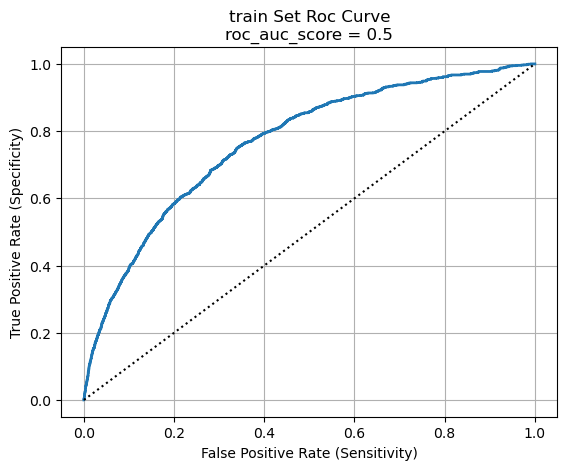


Check Precision-Recall Curve and Average Precision Score


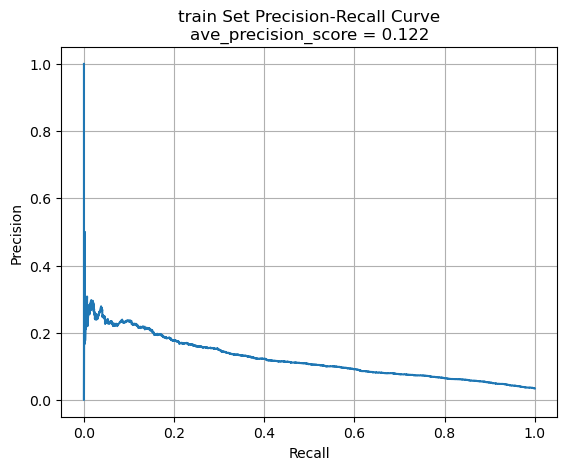

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,train,0.9655,0.0,0.0,0.9654,0.0,0.0,0.0,0.5


In [10]:
eval_train_results = bin_class_utils.eval_class(train_cap_x_df, train_y_df, best_model, "train", CVS_SCORING_LIST)
eval_train_results

#### 5. Evaluate hyperparameter-tuned estimator on validation set

In [11]:
validation_df = general_utils.read_csv(VALIDATION_FILE_PATH)


Read CSV file ../data/validation_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1451378,2082,3033,7,154,56,5,11,31,40,...,4,20,-1,-1,7,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,17,5,0
1,1619957,1225,4676,7,178,17,5,17,70,39,...,4,20,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,6,0
2,1698084,2206,2822,7,177,56,5,14,31,40,...,5,20,1,-1,2,-1,-1,17,3,0
3,1983802,5103,2564,7,151,60,4,12,23,26,...,4,20,-1,-1,8,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,39,5,0
4,1537560,1098,1732,7,134,55,4,17,65,18,...,4,20,-1,-1,2,3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20...,12,14,1,0


df.shape: (167629, 36)


In [12]:
validation_df_sample = data_prepare_utils.sample_data(validation_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del validation_df


Sample 0.05 fraction from DataFrame:
sample_df.shape: (8381, 36)


In [13]:
validation_cap_x_df, validation_y_df = validation_df_sample.drop(columns=TARGET_ATTR), validation_df_sample[[TARGET_ATTR]]
del validation_df_sample

Evaluate the trained estimator performance on validation set
Check accuracy score
validation set accuracy score: 0.9655172413793104

Check classification report
{'0': {'precision': 0.9655172413793104, 'recall': 1.0, 'f1-score': 0.9824561403508771, 'support': 8092.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 289.0}, 'accuracy': 0.9655172413793104, 'macro avg': {'precision': 0.4827586206896552, 'recall': 0.5, 'f1-score': 0.49122807017543857, 'support': 8381.0}, 'weighted avg': {'precision': 0.9322235434007135, 'recall': 0.9655172413793104, 'f1-score': 0.9485783424077434, 'support': 8381.0}}

Check confusion matrix
validation set confusion matrix: 
[[8092    0]
 [ 289    0]]
True Positives =  8092
True Negatives =  0
False Positives(Type I error) =  0
False Negatives(Type II error) =  289

Check cross validation score


/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


accuracy scores: [0.96481813 0.96479714 0.96599045 0.96539379 0.96539379]
np.mean(scores): 0.9653
np.std(scores, ddof=1): 0.0005


/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



precision scores: [0. 0. 1. 0. 0.]
np.mean(scores): 0.2000
np.std(scores, ddof=1): 0.4472

recall scores: [0.         0.         0.01724138 0.         0.        ]
np.mean(scores): 0.0034
np.std(scores, ddof=1): 0.0077

f1 scores: [0.         0.         0.03389831 0.         0.        ]
np.mean(scores): 0.0068
np.std(scores, ddof=1): 0.0152

Check the ROC Curve and AUC


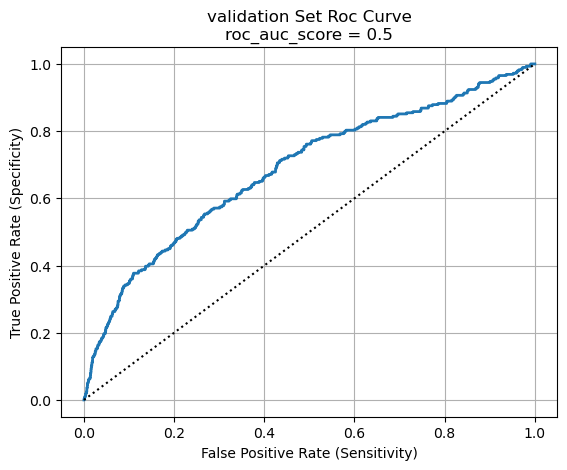


Check Precision-Recall Curve and Average Precision Score


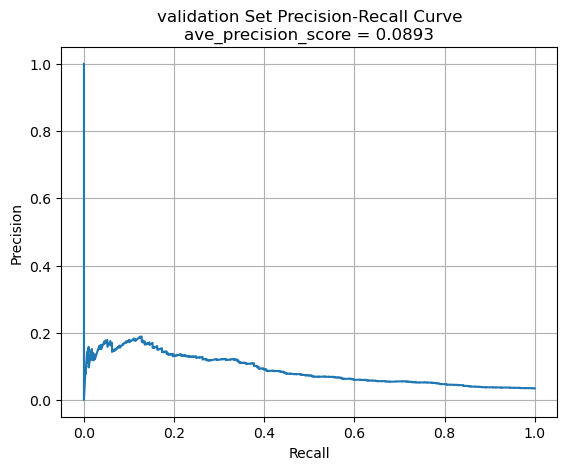

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,validation,0.9655,0.0,0.0,0.9653,0.2,0.0034,0.0068,0.5


In [14]:
eval_validation_results = bin_class_utils.eval_class(validation_cap_x_df, validation_y_df, best_model, "validation", CVS_SCORING_LIST)
eval_validation_results

#### 6. Check out permutation feature importance

In [15]:
perm_results_df = bin_class_utils.check_out_permutation_importance(
    best_model, 
    train_cap_x_df, 
    train_y_df, 
    PERMUTATION_IMPORTANCE_RANDOM_STATE,
    PERMUTATION_SCORING_LIST
)
perm_results_df


Check out permutation importance:


,metric_name,feature_name,metric_mean,metric_std_dev
0,average_precision,adv_id,0.049233,0.001643
1,average_precision,slot_id,0.039591,0.003323
2,average_precision,his_app_size,0.021800,0.001682
3,average_precision,age,0.019206,0.001968
4,average_precision,app_first_class,0.008379,0.000722
5,average_precision,city,0.006172,0.000814
6,average_precision,net_type,0.000994,0.000402
7,roc_auc,adv_id,0.096068,0.003802
8,roc_auc,slot_id,0.060988,0.005100
9,roc_auc,age,0.014243,0.001602


#### 7. Check for false discoveries

In [16]:
# bin_class_utils.avoiding_false_discoveries_class_helper(
#     best_model, 
#     train_cap_x_df, 
#     train_y_df, 
#     validation_cap_x_df,
#     validation_y_df, 
#     num_samples=BS_SAMPLE_NUM
# )

#### 8. Tune classification threshold for classification - assess threshold list

In [17]:
thresholds = np.arange(0, 1.1, 0.1)

bin_class_utils.print_classification_metrics_at_thresholds(
    validation_cap_x_df, 
    validation_y_df,
    best_model,  
    thresholds
)


Classification Report at Threshold 0.00:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      8092
           1     0.0345    1.0000    0.0667       289

    accuracy                         0.0345      8381
   macro avg     0.0172    0.5000    0.0333      8381
weighted avg     0.0012    0.0345    0.0023      8381


Classification Report at Threshold 0.10:

              precision    recall  f1-score   support

           0     0.9701    0.9666    0.9684      8092
           1     0.1509    0.1661    0.1582       289

    accuracy                         0.9390      8381
   macro avg     0.5605    0.5664    0.5633      8381
weighted avg     0.9419    0.9390    0.9404      8381


Classification Report at Threshold 0.20:

              precision    recall  f1-score   support

           0     0.9658    0.9979    0.9816      8092
           1     0.1500    0.0104    0.0194       289

    accuracy                         0.9638      8381

/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


Classification Report at Threshold 0.80:

              precision    recall  f1-score   support

           0     0.9655    1.0000    0.9825      8092
           1     0.0000    0.0000    0.0000       289

    accuracy                         0.9655      8381
   macro avg     0.4828    0.5000    0.4912      8381
weighted avg     0.9322    0.9655    0.9486      8381


Classification Report at Threshold 0.90:

              precision    recall  f1-score   support

           0     0.9655    1.0000    0.9825      8092
           1     0.0000    0.0000    0.0000       289

    accuracy                         0.9655      8381
   macro avg     0.4828    0.5000    0.4912      8381
weighted avg     0.9322    0.9655    0.9486      8381


Classification Report at Threshold 1.00:

              precision    recall  f1-score   support

           0     0.9655    1.0000    0.9825      8092
           1     0.0000    0.0000    0.0000       289

    accuracy                         0.9655      8381

/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

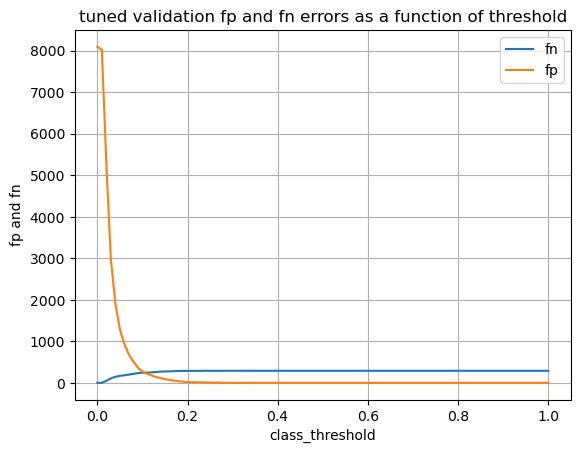

In [18]:
bin_class_utils.plot_errors_to_threshold(
    best_model, 
    validation_cap_x_df, 
    validation_y_df, 
    'tuned validation'
)

#### 9. Higher resolution scan to get the best classification threshold

In [19]:
temp_best_threshold = 0.10

In [20]:
start = temp_best_threshold - 0.05
stop = temp_best_threshold + 0.06
step_size = 0.01

narrow_thresholds = np.arange(start, stop, step_size)
bin_class_utils.print_classification_metrics_at_thresholds(
    validation_cap_x_df, 
    validation_y_df,
    best_model,
    narrow_thresholds
)


Classification Report at Threshold 0.05:

              precision    recall  f1-score   support

           0     0.9761    0.8413    0.9037      8092
           1     0.0868    0.4221    0.1440       289

    accuracy                         0.8269      8381
   macro avg     0.5314    0.6317    0.5238      8381
weighted avg     0.9454    0.8269    0.8775      8381


Classification Report at Threshold 0.06:

              precision    recall  f1-score   support

           0     0.9755    0.8856    0.9284      8092
           1     0.1053    0.3772    0.1647       289

    accuracy                         0.8680      8381
   macro avg     0.5404    0.6314    0.5465      8381
weighted avg     0.9455    0.8680    0.9020      8381


Classification Report at Threshold 0.07:

              precision    recall  f1-score   support

           0     0.9741    0.9165    0.9444      8092
           1     0.1198    0.3183    0.1741       289

    accuracy                         0.8958      8381

In [21]:
best_threshold = 0.13

#### 10. Evaluate the best classification threshold on validation set

Evaluate the trained estimator performance on best validation set
Check accuracy score
best validation set accuracy score: 0.9523923159527503

Check classification report
{'0': {'precision': 0.96845694799659, 'recall': 0.9826989619377162, 'f1-score': 0.9755259768140834, 'support': 8092.0}, '1': {'precision': 0.17647058823529413, 'recall': 0.10380622837370242, 'f1-score': 0.13071895424836602, 'support': 289.0}, 'accuracy': 0.9523923159527503, 'macro avg': {'precision': 0.572463768115942, 'recall': 0.5432525951557093, 'f1-score': 0.5531224655312247, 'support': 8381.0}, 'weighted avg': {'precision': 0.9411470735220625, 'recall': 0.9523923159527503, 'f1-score': 0.9463947001738862, 'support': 8381.0}}

Check confusion matrix
best validation set confusion matrix: 
[[7952  140]
 [ 259   30]]
True Positives =  7952
True Negatives =  30
False Positives(Type I error) =  140
False Negatives(Type II error) =  259

Check cross validation score

accuracy scores: [0.96481813 0.96479714 0.96599045 0.9

/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



precision scores: [0. 0. 1. 0. 0.]
np.mean(scores): 0.2000
np.std(scores, ddof=1): 0.4472

recall scores: [0.         0.         0.01724138 0.         0.        ]
np.mean(scores): 0.0034
np.std(scores, ddof=1): 0.0077

f1 scores: [0.         0.         0.03389831 0.         0.        ]
np.mean(scores): 0.0068
np.std(scores, ddof=1): 0.0152

Check the ROC Curve and AUC


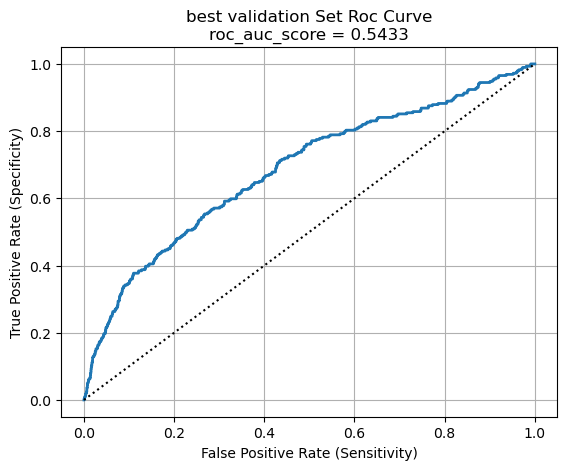


Check Precision-Recall Curve and Average Precision Score


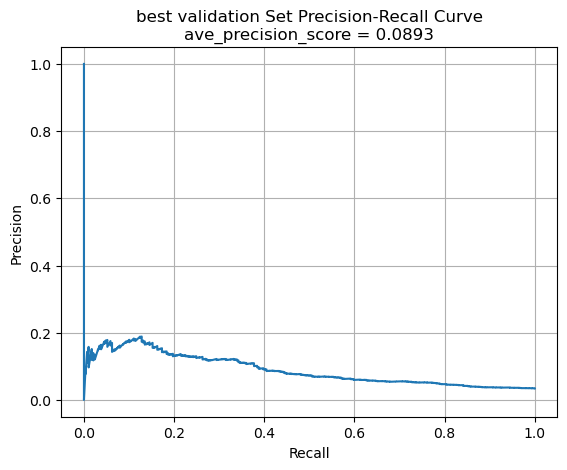

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,best validation,0.9524,0.176471,0.103806,0.9653,0.2,0.0034,0.0068,0.5433


In [22]:
eval_best_validation_results = bin_class_utils.eval_class(
    validation_cap_x_df,
    validation_y_df,
    best_model,
    "best validation",
    CVS_SCORING_LIST,
    best_threshold
)
eval_best_validation_results

In [23]:
compare_df = pd.concat([eval_train_results, eval_validation_results, eval_best_validation_results], axis=0)
compare_df

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,train,0.9655,0.000000,0.000000,0.9654,0.0,0.0000,0.0000,0.5000
0,validation,0.9655,0.000000,0.000000,0.9653,0.2,0.0034,0.0068,0.5000
0,best validation,0.9524,0.176471,0.103806,0.9653,0.2,0.0034,0.0068,0.5433


#### 11. Save the best model with pickle

In [24]:
pickle.dump(best_model, open(ESTIMATOR_NAME + '.pkl', 'wb'))

In [25]:
end_time = time.time()
print(f'Script run time: {(end_time - start_time)/60} minutes')

Script run time: 12.379420034090678 minutes
